<a href="https://colab.research.google.com/github/nicoleli04/CSE151A-Project/blob/Milestone-4/Milestone_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -r CSE151A-Project
!git clone https://github.com/nicoleli04/CSE151A-Project

Cloning into 'CSE151A-Project'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 318 (delta 123), reused 127 (delta 73), pack-reused 128
Receiving objects: 100% (318/318), 23.26 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#original datasets:
sephora = pd.read_csv('/content/CSE151A-Project/SephoraData.csv')
indonesia = pd.read_csv('/content/CSE151A-Project/IndonesiaReviews.csv')
skinsort = pd.read_csv('/content/CSE151A-Project/SkinsortData.csv')


# Data Preprocessing

In [ ]:
indonesia.rename(columns = {"Product": "name", "OverallRating": "rating"}, inplace = True)
sephora.rename(columns = {"product_name": "name"}, inplace = True)
s = sephora[['name', 'rating']] #add price?
i = indonesia[['name', 'rating']]
reviews = pd.concat([s, i]) #concatenate the two datasets into the reviews dataset
i.head()
s.head()
reviews.head()
reviews.shape
# reviews.value_counts('name')
reviews = reviews.drop_duplicates(subset=['name']) #drop duplicates
reviews.shape
# reviews.value_counts('name')

(9195, 2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer #to vectorize
from sklearn.metrics.pairwise import cosine_similarity #to create the similarity matrix
import re #regular expression operations

# Create DataFrames
products_df = pd.DataFrame(skinsort)
reviews_df = pd.DataFrame(reviews)

# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

products_df['name'] = products_df['name'].apply(preprocess_text)
reviews_df['name'] = reviews_df['name'].apply(preprocess_text)

# Vectorize text data
vectorizer = TfidfVectorizer()
tfidf_products = vectorizer.fit_transform(products_df['name'])
tfidf_reviews = vectorizer.transform(reviews_df['name'])
# Calculate similarity scores
similarity_matrix = cosine_similarity(tfidf_reviews, tfidf_products)

# Initialize a list to hold the matched products
matched_products = []
similarity_threshold = 0.4  # Set your desired similarity threshold here

# Copy similarity_matrix to avoid modifying the original
sim_matrix_copy = similarity_matrix.copy()

# Loop through each review
for i in range(len(reviews_df)):
    # Find the index of the highest similarity score for the current review
    best_match_idx = np.argmax(sim_matrix_copy[i])
    # Check if the highest similarity score is above the threshold
    if sim_matrix_copy[i, best_match_idx] >= similarity_threshold:
        # Append the matched product from products_df
        matched_products.append(products_df['name'].iloc[best_match_idx])
        # Set the highest similarity score to a very low value to prevent re-matching
        sim_matrix_copy[:, best_match_idx] = -1
    else:
        # If no match is found above the threshold, append None
        matched_products.append(None)

# Add the matched products to the reviews_df
reviews_df['Matched_Product'] = matched_products

# Merge the reviews into the products DataFrame based on the best matches
merged_df = products_df.merge(reviews_df.drop(columns='name'), left_on='name', right_on='Matched_Product', how='left')

# Remove entries where no product was matched (Matched_Product is None)
merged_df = merged_df.dropna(subset=['Matched_Product', 'rating'])

# Drop duplicates and unnecessary columns
merged_df = merged_df.drop_duplicates('name').drop_duplicates('Matched_Product').drop(columns=['Matched_Product'])

# Display the merged DataFrame
merged_df
merged_df.to_csv('finalskincarelist_df.csv', index=False)
merged_df.head()


,brand,name,type,country,ingridients,afterUse,rating
0,The Ordinary,glycolic acid 7 toning solution,Toner,Canada,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ...",4.3456
2,The Ordinary,niacinamide 10 zinc 1,Facial Treatment,Canada,"Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...","Good For Oily Skin,Redness Reducing,Acne Fight...",3.9000
3,Youth To The People,superfood antioxidant cleanser,Face Cleanser,United States,"Water,Cocamidopropyl Hydroxysultaine,Sodium Co...","Redness Reducing,Reduces Irritation,Skin Textu...",4.2112
4,COSRX,low ph good morning gel cleanser,Face Cleanser,South Korea,"Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...","Good For Oily Skin,Reduces Irritation,Reduces ...",4.0000
6,The Ordinary,azelaic acid suspension 10,Serum,Canada,"Water,Isodecyl Neopentanoate,Dimethicone,Azela...","Redness Reducing,Anti-Aging,Dark Spots,Scar He...",4.1578


In [ ]:
encoded_results = pd.get_dummies(merged_df['afterUse'])
encoded_results = pd.concat([merged_df, encoded_results], axis=1)
encoded_results.head()

,brand,name,type,country,ingridients,afterUse,rating,"Acne Fighting,Brightening,Acne Trigger,Eczema","Acne Fighting,Brightening,Eczema","Acne Fighting,Drying,Irritating,Eczema",...,"Scar Healing,Brightening,May Worsen Oily Skin,Rosacea","Scar Healing,Brightening,Rosacea","Scar Healing,Brightening,Rosacea,Eczema","Scar Healing,Drying,Acne Trigger","Scar Healing,Drying,Acne Trigger,Irritating,Rosacea,Eczema","Scar Healing,Drying,May Worsen Oily Skin,Acne Trigger,Rosacea","Scar Healing,Eczema","Scar Healing,May Worsen Oily Skin","Scar Healing,May Worsen Oily Skin,Acne Trigger","Scar Healing,Rosacea"
0,The Ordinary,glycolic acid 7 toning solution,Toner,Canada,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ...",4.3456,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,The Ordinary,niacinamide 10 zinc 1,Facial Treatment,Canada,"Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...","Good For Oily Skin,Redness Reducing,Acne Fight...",3.9000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Youth To The People,superfood antioxidant cleanser,Face Cleanser,United States,"Water,Cocamidopropyl Hydroxysultaine,Sodium Co...","Redness Reducing,Reduces Irritation,Skin Textu...",4.2112,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,COSRX,low ph good morning gel cleanser,Face Cleanser,South Korea,"Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...","Good For Oily Skin,Reduces Irritation,Reduces ...",4.0000,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,The Ordinary,azelaic acid suspension 10,Serum,Canada,"Water,Isodecyl Neopentanoate,Dimethicone,Azela...","Redness Reducing,Anti-Aging,Dark Spots,Scar He...",4.1578,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
#Changing the column names
merged_df.rename(columns = {"brand": "Brand", "name": "Name", "type": "Type", "country": "Country", "ingridients":"Ingredients", "afterUse": "Results", "rating": "Rating"}, inplace = True)
merged_df.head()

,Brand,Name,Type,Country,Ingredients,Results,Rating
0,The Ordinary,glycolic acid 7 toning solution,Toner,Canada,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ...",4.3456
2,The Ordinary,niacinamide 10 zinc 1,Facial Treatment,Canada,"Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...","Good For Oily Skin,Redness Reducing,Acne Fight...",3.9000
3,Youth To The People,superfood antioxidant cleanser,Face Cleanser,United States,"Water,Cocamidopropyl Hydroxysultaine,Sodium Co...","Redness Reducing,Reduces Irritation,Skin Textu...",4.2112
4,COSRX,low ph good morning gel cleanser,Face Cleanser,South Korea,"Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...","Good For Oily Skin,Reduces Irritation,Reduces ...",4.0000
6,The Ordinary,azelaic acid suspension 10,Serum,Canada,"Water,Isodecyl Neopentanoate,Dimethicone,Azela...","Redness Reducing,Anti-Aging,Dark Spots,Scar He...",4.1578


In [ ]:
#Dropped the null values in the Results column:
merged_df.dropna(subset=['Results'], inplace=True)
merged_df.shape


(5584, 7)

In [ ]:
display("Description", merged_df.describe())
display(merged_df.head())
display("Columns:", merged_df.columns)
display("Data Types:", merged_df.dtypes)

'Description'

,Rating
count,5584.000000
mean,4.175367
std,0.493009
min,1.000000
25%,3.954125
50%,4.262100
75%,4.503075
max,5.000000


,Brand,Name,Type,Country,Ingredients,Results,Rating
0,The Ordinary,glycolic acid 7 toning solution,Toner,Canada,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ...",4.3456
2,The Ordinary,niacinamide 10 zinc 1,Facial Treatment,Canada,"Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...","Good For Oily Skin,Redness Reducing,Acne Fight...",3.9000
3,Youth To The People,superfood antioxidant cleanser,Face Cleanser,United States,"Water,Cocamidopropyl Hydroxysultaine,Sodium Co...","Redness Reducing,Reduces Irritation,Skin Textu...",4.2112
4,COSRX,low ph good morning gel cleanser,Face Cleanser,South Korea,"Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...","Good For Oily Skin,Reduces Irritation,Reduces ...",4.0000
6,The Ordinary,azelaic acid suspension 10,Serum,Canada,"Water,Isodecyl Neopentanoate,Dimethicone,Azela...","Redness Reducing,Anti-Aging,Dark Spots,Scar He...",4.1578


'Columns:'

Index(['Brand', 'Name', 'Type', 'Country', 'Ingredients', 'Results', 'Rating'], dtype='object')

'Data Types:'

,0
Brand,object
Name,object
Type,object
Country,object
Ingredients,object
Results,object
Rating,float64


# Data Exploration


Creating ingredients to predict whether a product is good for acne or not. Linear regression where y (output) = Helps with acne or not

In [ ]:
acne_df = merged_df[[ 'Name', 'Ingredients', 'Results']]

In [ ]:
print(acne_df.shape)
display(acne_df.head())
display(acne_df.columns)
display(acne_df.dtypes)

(5584, 3)


,Name,Ingredients,Results
0,glycolic acid 7 toning solution,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ..."
2,niacinamide 10 zinc 1,"Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...","Good For Oily Skin,Redness Reducing,Acne Fight..."
3,superfood antioxidant cleanser,"Water,Cocamidopropyl Hydroxysultaine,Sodium Co...","Redness Reducing,Reduces Irritation,Skin Textu..."
4,low ph good morning gel cleanser,"Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...","Good For Oily Skin,Reduces Irritation,Reduces ..."
6,azelaic acid suspension 10,"Water,Isodecyl Neopentanoate,Dimethicone,Azela...","Redness Reducing,Anti-Aging,Dark Spots,Scar He..."


Index(['Name', 'Ingredients', 'Results'], dtype='object')

,0
Name,object
Ingredients,object
Results,object


In [ ]:
acne_df.isna().sum()

,0
Name,0
Ingredients,0
Results,0


In [ ]:
acne_df.shape

(5584, 3)

In [ ]:
# acne_df.Results.value_counts()

In [ ]:
# acne_df['Acne'] = acne_df['Results'].str.lower().contains("acne")

In [ ]:
# old line
acne_df['contains_acne'] = acne_df['Results'].str.contains('acne', case=False, na=False)

<ipython-input-67-f59fa7a392dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acne_df['contains_acne'] = acne_df['Results'].str.contains('acne', case=False, na=False)


In [ ]:
# new line
acne_df['acne_fighting'] = acne_df['Results'].str.contains('Acne Fighting', case=False, na=False)

<ipython-input-68-7b9ba996ecf9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acne_df['acne_fighting'] = acne_df['Results'].str.contains('Acne Fighting', case=False, na=False)


In [ ]:
acne_df.head()

,Name,Ingredients,Results,contains_acne,acne_fighting
0,glycolic acid 7 toning solution,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ...",True,False
2,niacinamide 10 zinc 1,"Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...","Good For Oily Skin,Redness Reducing,Acne Fight...",True,True
3,superfood antioxidant cleanser,"Water,Cocamidopropyl Hydroxysultaine,Sodium Co...","Redness Reducing,Reduces Irritation,Skin Textu...",True,False
4,low ph good morning gel cleanser,"Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...","Good For Oily Skin,Reduces Irritation,Reduces ...",True,False
6,azelaic acid suspension 10,"Water,Isodecyl Neopentanoate,Dimethicone,Azela...","Redness Reducing,Anti-Aging,Dark Spots,Scar He...",False,False


In [ ]:
acne_df['contains_acne'].value_counts()

,count
contains_acne,
True,3325
False,2259


In [ ]:
acne_df = acne_df.loc[acne_df["contains_acne"] == True]

In [ ]:
acne_df.head()

,Name,Ingredients,Results,contains_acne,acne_fighting
0,glycolic acid 7 toning solution,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ...",True,False
2,niacinamide 10 zinc 1,"Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...","Good For Oily Skin,Redness Reducing,Acne Fight...",True,True
3,superfood antioxidant cleanser,"Water,Cocamidopropyl Hydroxysultaine,Sodium Co...","Redness Reducing,Reduces Irritation,Skin Textu...",True,False
4,low ph good morning gel cleanser,"Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...","Good For Oily Skin,Reduces Irritation,Reduces ...",True,False
7,advanced snail 92 all in one cream,"Snail Secretion Filtrate,Betaine,Caprylic/Capr...","Redness Reducing,Reduces Irritation,May Worsen...",True,False


In [ ]:
acne_df.contains_acne.value_counts()

,count
contains_acne,
True,3325


In [ ]:
# acne_df.Results.value_counts() #Acne Trigger  #Acne Fighting

In [ ]:
acne_df['Acne Fighting'] = acne_df['Results'].str.contains('acne fighting', case=False, na=False)

In [ ]:
acne_df.sample(10)

,Name,Ingredients,Results,contains_acne,acne_fighting,Acne Fighting
19087,blemish control cleanser,"Salicylic Acid 2%,Water,Sodium Lauroyl Sarcosi...","Good For Oily Skin,Redness Reducing,Reduces La...",True,True,True
280,resurrection repair shampoo for damaged hair,"Water,Sodium Laureth Sulfate,Dimethiconol,Glyc...","Reduces Large Pores,Drying,Acne Trigger,Irrita...",True,False,False
9751,firmly yours toning dry body oil,"Coco-Caprylate/Caprate,Crambe Abyssinica Seed ...","Hydrating,Reduces Irritation,Anti-Aging,Scar H...",True,False,False
246,stay matte pressed powder 006 warm beige,"Talc,Magnesium Stearate,Mica,Polyethylene,Petr...","Brightening,May Worsen Oily Skin,Acne Trigger,...",True,False,False
2803,peony scented liquid hand soap,"Water,Cocamidopropyl Hydroxysultaine,Sodium Me...","Reduces Large Pores,Drying,Acne Trigger,Irrita...",True,False,False
13845,cold plunge pore remedy moisturizer,"Water,Propanediol,Dicaprylyl Carbonate,Glyceri...","Hydrating,Good For Oily Skin,Reduces Irritatio...",True,True,True
6450,emulsion d fortifying moisturizer,"Water,Glycerin,Behenyl Alcohol,Coco-Caprylate/...","Hydrating,Redness Reducing,Anti-Aging,Scar Hea...",True,False,False
9634,willow sweet agave plumping lip mask,"Hydroxystearic/Linolenic/Oleic Polyglycerides,...","Reduces Irritation,Anti-Aging,Scar Healing,Bri...",True,False,False
16115,clear skin cleansing gel,"Water,Aloe Barbadensis Leaf Juice,Sodium Laure...","Good For Oily Skin,Reduces Irritation,Skin Tex...",True,False,False
19384,brightening elixir,"Water,Glycerin,Cellulose Gum,Sodium Hyaluronat...","Redness Reducing,Reduces Irritation,Skin Textu...",True,True,True


In [ ]:
acne_df.loc[acne_df["Results"].str.contains('acne trigger', case=False, na=False)].shape

(2621, 6)

In [ ]:
acne_df.loc[acne_df["Results"].str.contains('acne fighting', case=False, na=False)].shape

(1244, 6)

In [ ]:
acne_df.shape

(3325, 6)

In [ ]:
acne_df['Acne Fighting'].value_counts()

,count
Acne Fighting,
False,2081
True,1244


In [ ]:
# acne_df.loc[acne_df["Results"].str.contains('acne fighting', case=False, na=False).str.contains('acne trigger', case=False, na=False)].shape

In [ ]:
acne_df.head()

,Name,Ingredients,Results,contains_acne,acne_fighting,Acne Fighting
0,glycolic acid 7 toning solution,"Water,Glycolic Acid,Rosa Damascena Flower Wate...","Good For Oily Skin,Skin Texture,Reduces Large ...",True,False,False
2,niacinamide 10 zinc 1,"Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...","Good For Oily Skin,Redness Reducing,Acne Fight...",True,True,True
3,superfood antioxidant cleanser,"Water,Cocamidopropyl Hydroxysultaine,Sodium Co...","Redness Reducing,Reduces Irritation,Skin Textu...",True,False,False
4,low ph good morning gel cleanser,"Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...","Good For Oily Skin,Reduces Irritation,Reduces ...",True,False,False
7,advanced snail 92 all in one cream,"Snail Secretion Filtrate,Betaine,Caprylic/Capr...","Redness Reducing,Reduces Irritation,May Worsen...",True,False,False


# Training the Logistic Regression Model

## Imports

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Defining our X and y

In [ ]:
product_names = acne_df['Name']
X = acne_df[['Ingredients']]
y = acne_df['Acne Fighting']

##Transforming Data

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

def str_to_list(x):
   return x.strip().split(',')


X['Ingredients'] = X['Ingredients'].dropna().apply(str_to_list)

<ipython-input-86-5a5487890afc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Ingredients'] = X['Ingredients'].dropna().apply(str_to_list)


In [ ]:
mlb = MultiLabelBinarizer()

one_hot_encoded = mlb.fit_transform(X['Ingredients'])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

X = one_hot_df
X.head()

,1,1-Methylhydantoin-2-Imide,10-Decanediol,10-Hydroxydecanoic Acid,2,2-Bromo-2-Nitropropane-1,2-Hexanediol,2-Hexanediol 19%,2-Hexanol,2-Hydroxyethyl Acrylate,...,Zingiber Cassumunar Root Oil,Zingiber Officinale Extract,Zingiber Officinale Root,Zingiber Officinale Root Extract,Zingiber Officinale Root Juice,Zingiber Officinale Root Oil,Zingiber Officinale Water,Zingiber Zerumbet Extract,Ziziphus Jujuba Leaf Extract,Ziziphus Jujuba Seed Extract
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# X.value_counts()

## Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Training our model and defining our predictive variables

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
yhat_test = model.predict(X_test)
yhat_train = model.predict(X_train)

## Model Accuracy and Confusion Matrix

In [ ]:
accuracy = accuracy_score(y_test, yhat_test)
conf_matrix = confusion_matrix(y_test, yhat_test)
class_report = classification_report(y_test, yhat_test)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9894736842105263
Confusion Matrix:
[[426   1]
 [  6 232]]
Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       427
        True       1.00      0.97      0.99       238

    accuracy                           0.99       665
   macro avg       0.99      0.99      0.99       665
weighted avg       0.99      0.99      0.99       665



## Graphs

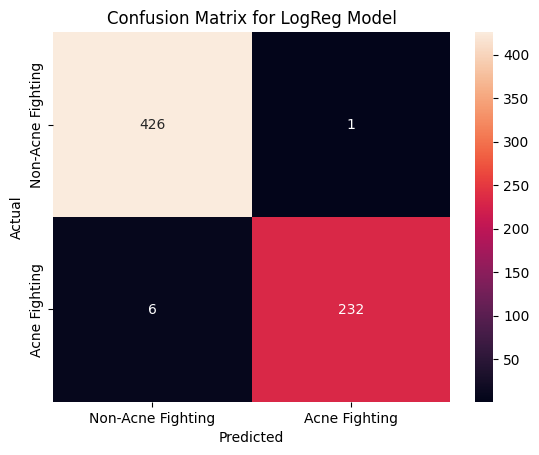

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['Non-Acne Fighting', 'Acne Fighting'], yticklabels=['Non-Acne Fighting', 'Acne Fighting'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LogReg Model')
plt.show()

<Axes: >

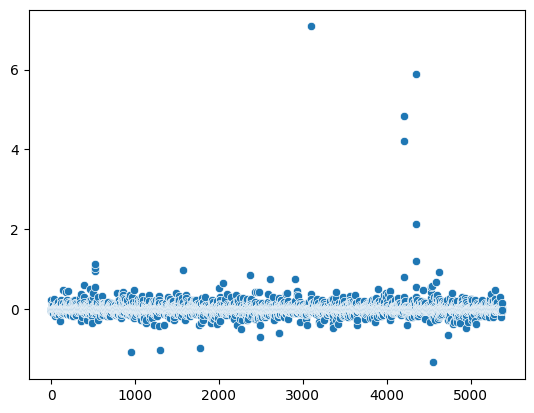

In [ ]:
sns.scatterplot(x = list(range(0,len(model.coef_[0]))),y = model.coef_[0])

Let's take a closer look at the ingredients that seem to contribute most to whether the product fights acne or not:

In [ ]:
coefs = model.coef_[0]
important_coefs = [i for i in range(len(coefs)) if coefs[i] > 2]
important_ingredients = mlb.classes_[important_coefs]
print([(i, j) for i, j in zip(important_ingredients, coefs[important_coefs])])

[('Niacinamide', 7.080718334478362), ('Retinol', 4.205409852048806), ('Retinyl Palmitate', 4.830736326390388), ('Salicylic Acid', 5.890054166964492), ('Salicylic Acid 2%', 2.1323922728819253)]


These are the top 5 ingredients that seem to help fight acne. This makes sense, because it correlates with past academic research that states ingredients such as Niacinamide, Retinol, and Salycic Acid all help to prevent acne.

#Training with Neural Network

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_nn = create_model()
history = model_nn.fit(X_train, y_train, epochs=10, batch_size=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7023 - loss: 0.5306
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9718 - loss: 0.2697
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9816 - loss: 0.2078
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9958 - loss: 0.1599
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9976 - loss: 0.1402
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9978 - loss: 0.1153
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9984 - loss: 0.0988
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9982 - loss: 0.0868
Epoch 9/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9985 - loss: 0.0755
Epoch 10/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9976 - loss: 0.0665


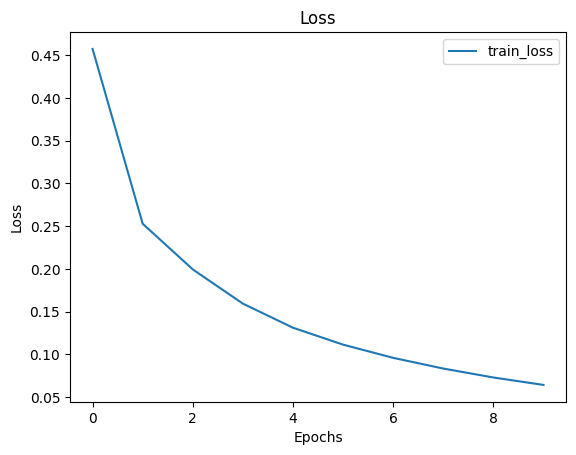

In [ ]:
# plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

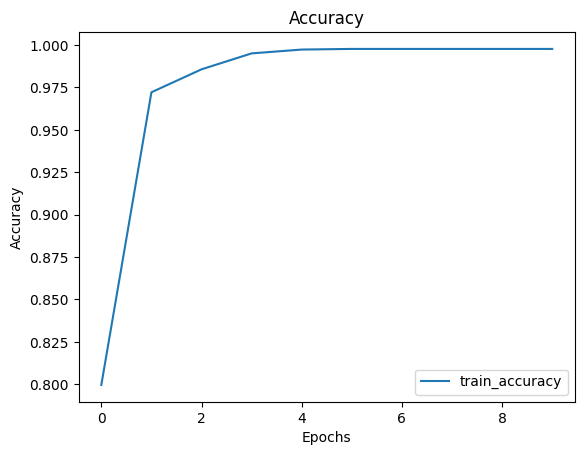

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
y_test_pred = model_nn.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

       False       0.95      0.98      0.97       427
        True       0.97      0.91      0.94       238

    accuracy                           0.96       665
   macro avg       0.96      0.95      0.95       665
weighted avg       0.96      0.96      0.96       665



In [ ]:
accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.956390977443609
Confusion Matrix:
[[420   7]
 [ 22 216]]


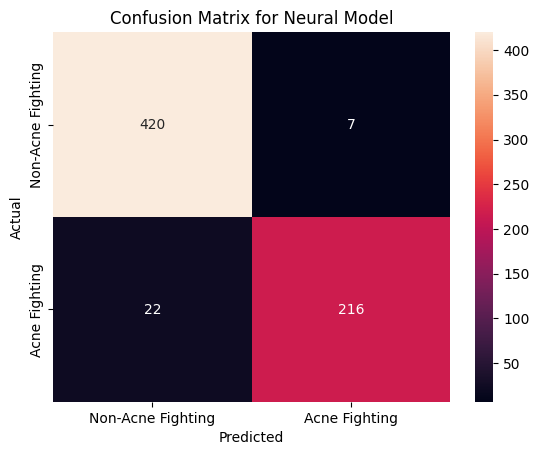

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['Non-Acne Fighting', 'Acne Fighting'], yticklabels=['Non-Acne Fighting', 'Acne Fighting'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Neural Network Model')
plt.show()